In [73]:
import numpy as np
from scipy import stats

In [74]:
def fit_line(stim_ests):
    #print("input stim_ests: ", np.shape(stim_ests))
    num_neuron = np.shape(stim_ests)[0]
    num_stim = 8
    baseline_start = 0
    baseline_duration = 7
    on_duration = 7
    on_start = 7
    response = stim_ests[:, baseline_start : baseline_start + baseline_duration]
    #print("ests? ", response, on_ests)
    regressor = np.linspace(baseline_start, baseline_duration - 1, baseline_duration)
    #print("input regressor and response shape for line fitting: ", np.shape(regressor), np.shape(response))
    coefficients = np.polyfit(regressor, response.T, deg=1).T
    res = stim_ests[:, baseline_start:baseline_start + baseline_duration] - [(regressor * coefficients[i, 0] + coefficients[i,1]) for i in range(num_neuron)]
    #print("maybe problem with res? ", res, np.shape(res))
    std = np.std(res, axis = 1, ddof=1)
    #print("okmaybe its std:\n", std, np.shape(std))
    total_regressor = np.linspace(0, 20, 21)
    frame_baseline = [(total_regressor * coefficients[i, 0] + coefficients[i,1] + 1.8*std[i]) for i in range(num_neuron)]
    print("get the shape of frame baseline \n", np.shape(frame_baseline))
    remains = stim_ests - frame_baseline
    avg_remains = np.mean(remains[:, 7:14], axis = 1)
    print("get the shape of frame remains ", np.shape(avg_remains))
    return avg_remains, remains

In [75]:
def fit_line_const(stim_ests):
    #print("input stim_ests: ", np.shape(stim_ests))
    num_neuron = np.shape(stim_ests)[0]
    num_stim = 8
    baseline_start = 0
    baseline_duration = 7
    on_duration = 7
    on_start = 7
    coefficient = np.zeros((num_neuron, 3))
    response = stim_ests[:, baseline_start : baseline_start + baseline_duration]
    on_ests = stim_ests[:, on_start : on_start + on_duration]
    on_regressor = np.linspace(on_start, on_start + on_duration - 1, on_duration)
    #print("ests? ", response, on_ests)
    regressor = np.linspace(baseline_start, baseline_duration - 1, baseline_duration)
    #print("input regressor and response shape for line fitting: ", np.shape(regressor), np.shape(response))
    coefficients = np.polyfit(regressor, response.T, deg=0).T
    res = stim_ests[:, baseline_start:baseline_start + baseline_duration] - (coefficients[:,0])[:, np.newaxis]
    #print("maybe problem with res? ", res, np.shape(res))
    std = np.std(res, axis = 1, ddof=1)
    #print("okmaybe its std:\n", std, np.shape(std))
    #logger.info("std shape for line fitting:{0}, {1}".format(np.shape(std), std))
    frame_baseline = coefficients[:,0] + 1.8 * std
    remains = stim_ests - frame_baseline[:, np.newaxis]
    avg_remains = np.mean(remains[:, 7:14], axis = 1)
    #print("get the shape of frame remains ", np.shape(avg_remains))
    return avg_remains, remains

In [76]:
def baseline_cal(p_t):
    num_stim = 8
    num_trial = 3
    num_neurons = np.shape(p_t)[0]
    res_stim = np.zeros((num_neurons, num_trial, num_stim))
    baseline_remains = np.zeros((num_neurons, 63, num_stim))
    for stim in range(num_stim):
        for trial in range(3):
            new_res, remains = fit_line(p_t[:, trial, stim*21: (stim+1)*21])
            baseline_remains[:, trial*21:(trial+1)*21, stim] = np.copy(remains)
            res_stim[:, trial, stim] = (res_stim[:, trial, stim] * trial + new_res) / (trial+1)
    res_stim = np.where(np.isnan(res_stim), 0, res_stim)
    res_stim[res_stim == np.inf] = 0
    res_avg = np.mean(res_stim, axis = 1)
    #print("the shape for res_avg: ", np.shape(res_avg))
    barcode = np.where(res_avg > 0, 1, 0)
    return res_avg, barcode, baseline_remains

def baseline_const_cal(p_t):
    num_stim = 8
    num_trial = 3
    num_neurons = np.shape(p_t)[0]
    res_stim = np.zeros((num_neurons, num_trial, num_stim))
    baseline_remains = np.zeros((num_neurons, 63, num_stim))
    for stim in range(num_stim):
        for trial in range(3):
            new_res, remains = fit_line_const(p_t[:, trial, stim*21: (stim+1)*21])
            baseline_remains[:, trial*21:(trial+1)*21, stim] = np.copy(remains)
            res_stim[:, trial, stim] = (res_stim[:, trial, stim] * trial + new_res) / (trial+1)
    res_stim = np.where(np.isnan(res_stim), 0, res_stim)
    res_stim[res_stim == np.inf] = 0
    res_avg = np.mean(res_stim, axis = 1)
    #print("the shape for res_avg: ", np.shape(res_stim), np.shape(res_avg))
    barcode = np.where(res_avg > 0, 1, 0)
    return res_avg, barcode, baseline_remains

In [77]:
def cal_pvalue(p_t):
    num_neurons = np.shape(p_t)[0]
    t_stats = []
    p_values = []
    ci_baseline_record = np.zeros((num_neurons, 2, 8))
    ci_on_record = np.zeros((num_neurons, 2, 8))
    mean_baseline_record = np.zeros((num_neurons, 8))
    mean_on_record = np.zeros((num_neurons, 8))
    for stim in range(8):
        pt_baseline = p_t[:, :, 21*stim : (21*(stim) + 7)]
        pt_on = p_t[:, :, (21*stim + 7) : (21*stim + 14)]
        #print("??????error?, ", np.shape(pt_baseline), np.shape(pt_on))
        pt_baseline_mean = np.mean(pt_baseline, axis = 2)
        pt_on_mean = np.mean(pt_on, axis = 2)
        #print("??????another errors?, ", np.shape(pt_baseline_mean), np.shape(pt_on_mean))
        mean_baseline_record[:, stim] = np.mean(pt_baseline_mean, axis = 1)
        mean_on_record[:, stim] = np.mean(pt_on_mean, axis = 1)
        for neuron in range(num_neurons):
            # if neuron == 47:
            #     print("aaaaaaaaaaaah, ", pt_baseline_mean[neuron], pt_on_mean[neuron], pt_baseline[neuron, :, ])
            #print("sanity test: ", np.shape(pt_baseline_mean[neuron]), pt_on_mean[neuron])
            ci_baseline = stats.t.interval(alpha=0.95,df=2,loc=np.mean(pt_baseline_mean[neuron]), scale=stats.sem(pt_baseline_mean[neuron]))
            #print("the shape of ci_baseline is ", ci_baseline, np.shape(np.array(ci_baseline)))
            ci_baseline_record[neuron, :, stim] = np.array([ci_baseline[0], ci_baseline[1]])
            ci_on = stats.t.interval(alpha=0.95,df=2,loc=np.mean(pt_on_mean[neuron]), scale=stats.sem(pt_on_mean[neuron]))
            assert((mean_baseline_record[neuron, stim] == np.mean(pt_baseline_mean[neuron])) and (mean_on_record[neuron, stim] == np.mean(pt_on_mean[neuron])))
            #print("the shape of ci_on is ", ci_on, np.shape(np.array(ci_on)))
            ci_on_record[neuron, :, stim] = np.array([ci_on[0], ci_on[1]])
        stat_res = stats.ttest_rel(pt_baseline_mean, pt_on_mean, axis = 1)
        t_stat = np.array(stat_res[0])
        p_value = np.array(stat_res[1])
        invalid_index = np.where(mean_on_record[:, stim] < mean_baseline_record[:, stim])
        p_value[invalid_index] = -1
        print(np.shape(p_value))
        t_stats.append(t_stat)
        p_values.append(p_value)
    t_stats = np.array(t_stats).T
    p_values = np.array(p_values).T
    return t_stats, p_values, ci_baseline_record, ci_on_record, mean_baseline_record, mean_on_record

In [78]:
def correlate_cal(pt_all):
    num_neurons = np.shape(pt_all)[0]
    slope_record = np.zeros((num_neurons, 3, 8))
    intercept_record = np.zeros((num_neurons, 3, 8))
    for trial in range(3):
        for stim in range(8):
            pt = pt_all[:, trial, 21*stim : 21*(stim + 1)]
            pt_base = pt[:, :7]
            pt_on = pt[:, 7:14]
            regressor = np.linspace(7, 13, 7)
            #print("input regressor and response shape for line fitting: ", np.shape(regressor), np.shape(response))
            coefficients = np.polyfit(regressor, pt_on.T, deg=1).T
            #print("??????? coefficients shape", np.shape(coefficients))
            slope = coefficients[:,0]
            intercept = coefficients[:,1]
            slope_record[:, trial, stim] = np.copy(slope)
            intercept_record[:, trial, stim] = np.copy(intercept)
    return slope_record, intercept_record


In [79]:
def cal_correlate_pvalue(slope):
    num_neurons = np.shape(slope)[0]
    p_record = np.zeros((num_neurons, 8))
    ci_record = np.zeros((num_neurons, 2, 8))
    slope_mean_record = np.zeros((num_neurons, 8))
    for stim in range(8):
        rvs = slope[:, :, stim]
        res = stats.ttest_1samp(rvs, popmean=0, axis = 1)
        for neuron in range(num_neurons):
            ci = stats.t.interval(alpha=0.95,df=2,loc=np.mean(rvs[neuron]), scale=stats.sem(rvs[neuron]))
            #print("the shape of ci is ", ci, ci[0], np.shape(np.array(ci)))
            ci_record[neuron, :, stim] = np.array([ci[0], ci[1]])
        p_value = np.copy(res[1])
        invalid_index = np.where(np.mean(rvs, axis = 1) < 0)
        p_value[invalid_index] = -1
        p_record[:, stim] = p_value
        slope_mean_record[:, stim] = np.mean(rvs, axis = 1)
    return p_record, ci_record, slope_mean_record
    

In [80]:
pt_all = np.load('data/o_t_1_nofilter_new.npy')

In [81]:
print(np.max(pt_all), np.min(pt_all))

3.1069778244268216 -0.5655099740483811


In [82]:
np.shape(pt_all)
#np.shape(select_pt)

(324, 3, 336)

In [83]:
fit_line_res_avg, fit_line_barcode, fit_line_remains = baseline_cal(pt_all)
fit_avg_res_avg, fit_avg_barcode, fit_avg_remains = baseline_const_cal(pt_all)

trial_avg_t, trial_avg_p, ci_baseline_record, ci_on_record, mean_baseline_record, mean_on_record = cal_pvalue(pt_all)

slope_record, intercept_record = correlate_cal(pt_all)
correlate_p, correlate_ci, correlate_mean = cal_correlate_pvalue(slope_record)

get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get the shape of frame baseline 
 (324, 21)
get the shape of frame remains  (324,)
get 

In [84]:
print(np.shape(slope_record))

(324, 3, 8)


In [85]:
slope_mean = np.mean(slope_record, axis = 1)
slope_sum = np.sum(np.abs(slope_mean), axis = 1)
slope_normalize = slope_mean / slope_sum[:, np.newaxis]


(324, 2)


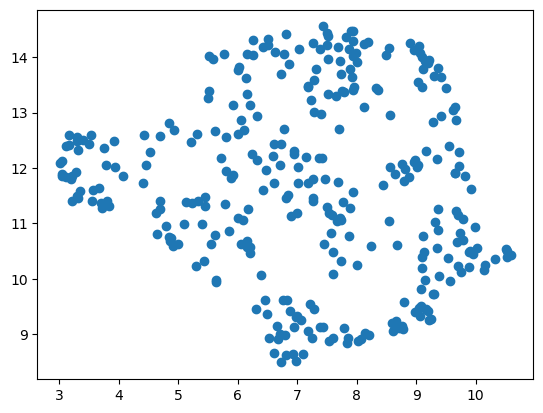

In [72]:
import umap
reducer = umap.UMAP()
res = reducer.fit_transform(slope_normalize)
print(np.shape(res))
plt.scatter(res[:, 0],res[:, 1])
#np.save('umap.out.npy', res)

(324, 2)


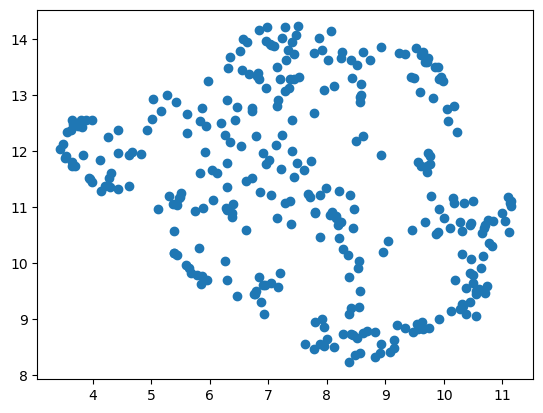

In [86]:
import umap
reducer = umap.UMAP()
res = reducer.fit_transform(slope_normalize)
print(np.shape(res))
plt.scatter(res[:, 0],res[:, 1])

In [ ]:
index_responsive = np.where(np.sum(fit_line_barcode, axis = 1) > 0)
print(len(index_responsive[0]))

In [ ]:
print(np.shape(fit_line_remains))

In [ ]:
import matplotlib.pyplot as plt
num_neurons = np.shape(pt_all)[0]
for neuron in range(num_neurons): #index_responsive[0][10:30]:
    rows, cols = 5, 8
    fig,ax = plt.subplots(rows, cols, figsize=(30, 15))
    x = np.linspace(0, 20, num=21)
    x_2 = np.linspace(0, 23, num=14)
    for stim in range(8):
        ot_record = pt_all[neuron, :, stim*21 : stim*21+21]
        ax[0, stim].set_ylim(-1, 4)
        ax[0, stim].axvline(x=7, color='r', linestyle='--')
        ax[0, stim].axvline(x=14, color='g', linestyle='--')
        for trial in range(3):   
            ax[0, stim].plot(x, ot_record[trial], linestyle='-')
        
        ot_fit_line_record = fit_line_remains[neuron, :,stim]
        ax[1, stim].text(2, 2, f'{round(fit_line_res_avg[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
        if fit_line_barcode[neuron, stim] == 1:
            ax[1, stim].set_facecolor('#FCFBEE')
        ax[1, stim].set_ylim(-3, 3)
        ax[1, stim].axvline(x=7, color='r', linestyle='--')
        ax[1, stim].axvline(x=14, color='g', linestyle='--')
        ax[1, stim].axhline(y=0, color='grey', linestyle='--')
        for trial in range(3):   
            ax[1, stim].plot(x, ot_fit_line_record[trial*21:trial*21+21], linestyle='-')

        ot_fit_avg_record = fit_avg_remains[neuron, :, stim]
        ax[2, stim].text(2, 2, f'{round(fit_avg_res_avg[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
        if fit_avg_barcode[neuron, stim] == 1:
            ax[2, stim].set_facecolor('#FCFBEE')
        ax[2, stim].set_ylim(-3, 3)
        ax[2, stim].axvline(x=7, color='r', linestyle='--')
        ax[2, stim].axvline(x=14, color='g', linestyle='--')
        ax[2, stim].axhline(y=0, color='grey', linestyle='--')
        for trial in range(3):   
            ax[2, stim].plot(x, ot_fit_avg_record[trial*21:trial*21+21], linestyle='-')

        ot_record = pt_all[neuron, :, stim*21 : stim*21+21]
        ax[3, stim].set_ylim(-1, 4)
        ax[3, stim].axvline(x=7, color='r', linestyle='--')
        ax[3, stim].axvline(x=14, color='g', linestyle='--')
        for trial in range(3):   
            ax[3, stim].plot(x, ot_record[trial], linestyle='-', color = 'lightgrey')
        ax[3, stim].plot((3,3),(ci_baseline_record[neuron, 0, stim],ci_baseline_record[neuron, 1, stim]),'-',color='blue')
        ax[3, stim].plot((10,10),(ci_on_record[neuron, 0, stim],ci_on_record[neuron, 1, stim]),'-',color='blue')
        ax[3, stim].scatter(3, mean_baseline_record[neuron, stim], color = 'blue')
        ax[3, stim].text(7, 3, f'p = {round(trial_avg_p[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
        ax[3, stim].scatter(10, mean_on_record[neuron, stim], color = 'blue')

        ot_record = pt_all[neuron, :, stim*21 : stim*21+21]
        ax[4, stim].set_ylim(-1, 4)
        ax[4, stim].axvline(x=7, color='r', linestyle='--')
        ax[4, stim].axvline(x=14, color='g', linestyle='--')
        for trial in range(3):   
            ax[4, stim].plot(x, ot_record[trial], linestyle='-', color = 'lightgrey')
            x_val = np.arange(7, 14, dtype = int)
            y_val = slope_record[neuron, trial, stim] * x_val + intercept_record[neuron, trial, stim]
            ax[4, stim].plot(x_val, y_val, '-', color = 'blue')
        ax[4, stim].text(7, 3, f'p = {round(correlate_p[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
    fig.show()
    fig.savefig(f'neuron_plot/pt_ttest_{neuron}.png')

In [5]:
test_mask = np.load("data/test_mask.npy")
np.savetxt('data/masks.csv', test_mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


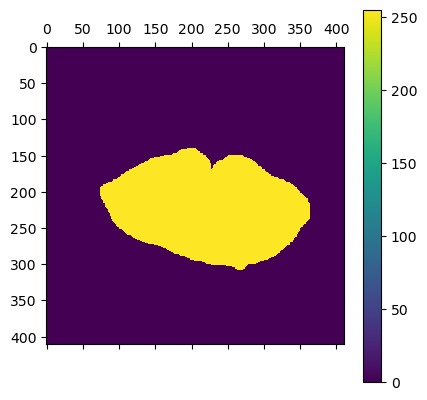

In [71]:
import numpy as np
import matplotlib.pyplot as plt
plt.matshow(test_mask)
plt.colorbar()
plt.show()

In [15]:
p1_neuron_loc = np.load('data/all_nz_neuron_array.npy')


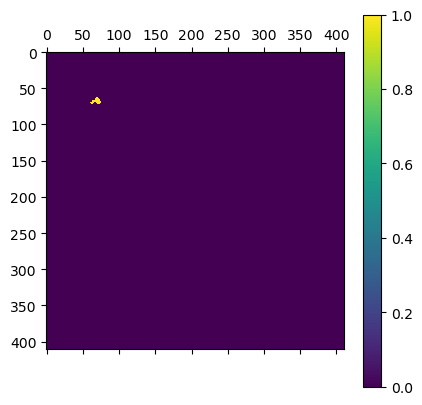

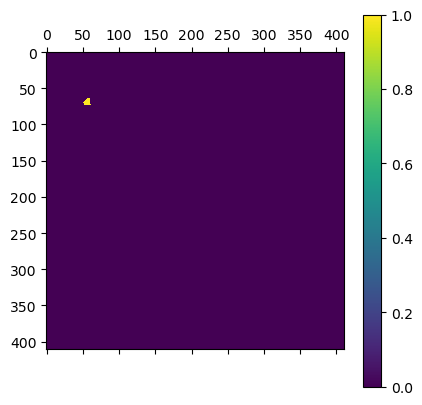

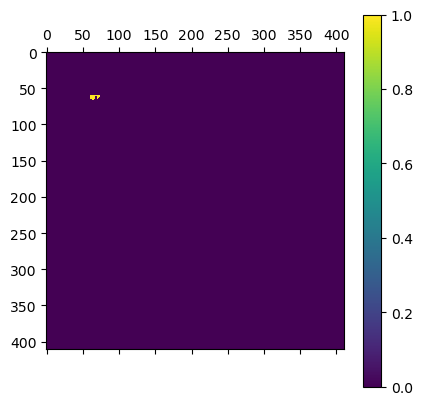

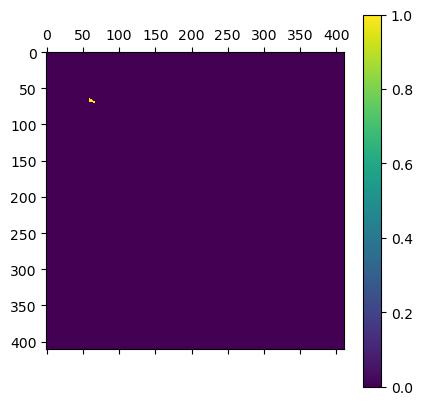

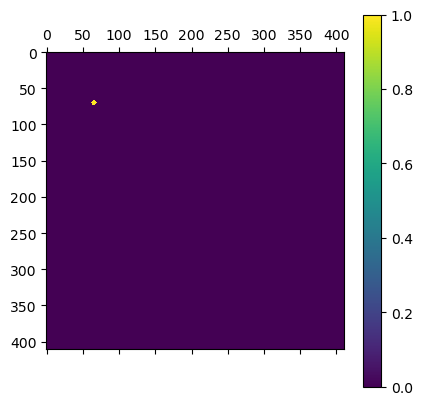

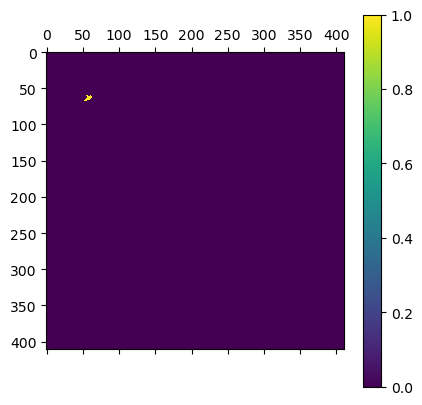

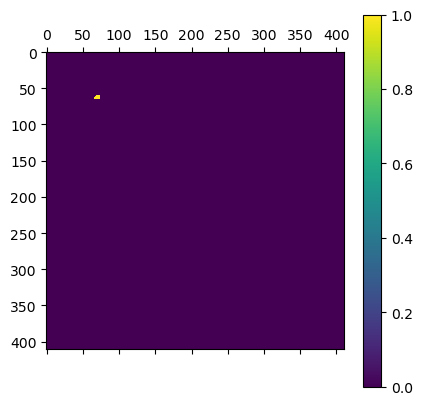

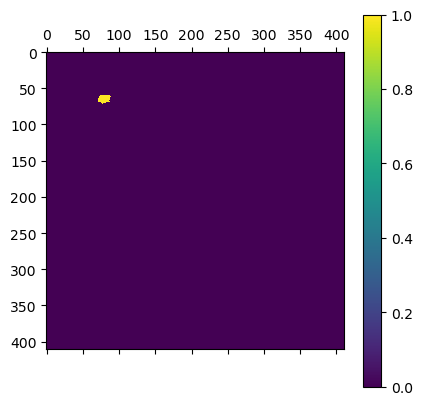

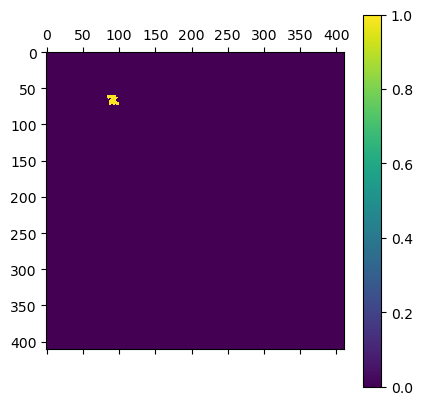

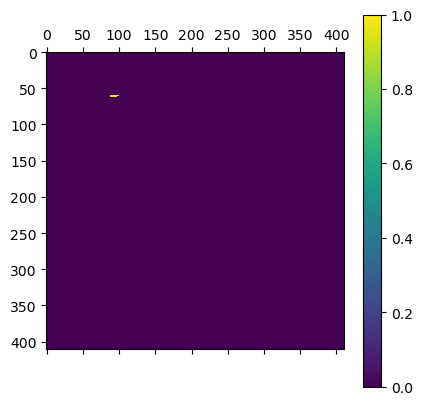

In [16]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(10):
    plt.matshow(test_neuron_loc[i])
    plt.colorbar()
    plt.show()

In [ ]:
index_responsive = np.where(barcode[:,0] > 0)
print(index_responsive)

In [ ]:
index_responsive = np.where(np.sum(barcode, axis = 1) > 0)
motion_responsive_pt = pt_all[index_responsive]
motion_responsive_est_avg = res_avg[index_responsive]
motion_responsive_barcode = barcode[index_responsive]

In [ ]:
print(np.shape(motion_responsive_pt))

In [ ]:
index_right_left = np.where(barcode[:, 0] > 0)
index_left_right = np.where(barcode[:, 1] > 0)
index_left_left = np.where(barcode[:, 2] > 0)
index_x_left = np.where(barcode[:, 3] > 0)
index_left_x = np.where(barcode[:, 4] > 0)
index_right_right = np.where(barcode[:, 5] > 0)
index_right_x = np.where(barcode[:, 6] > 0)
index_x_right = np.where(barcode[:, 7] > 0)


In [ ]:
t_stats = np.array(t_stats).T
p_values = np.array(p_values).T
print(np.shape(p_values))

In [ ]:
ot_dict = {}
ot_dict['iwd'] = {}
ot_dict['owd'] = {}
ot_dict['left'] = {}
ot_dict['m_left'] = {}
ot_dict['l_left'] = {}
ot_dict['right'] = {}
ot_dict['m_right'] = {}
ot_dict['l_right'] = {}
count = 0
for item in ot_dict.keys():
    index = np.where(barcode[:, count] > 0)
    print(index)
    (ot_dict[item])['index'] = index
    (ot_dict[item])['ests'] = pt_all[index]
    (ot_dict[item])['ests_avg'] = res_avg[index]
    (ot_dict[item])['barcode'] = barcode[index]
    count += 1
print(ot_dict)

In [ ]:
np.shape((ot_dict[item])['ests'])

In [ ]:
import matplotlib.pyplot as plt
num_neurons = np.shape(pt_all)[0]
for count in range(3):
    rows, cols = 100, 8
    fig,ax = plt.subplots(rows, cols, figsize=(30, 300))
    x = np.linspace(0, 20, num=21)
    for neuron in range(100*count, min(100*(count + 1), num_neuron)):
        for stim in range(cols):
            ax[neuron, stim].text(15, 3, f'{round(p_values[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
            ot_record = pt_all[neuron, :, stim*21 : stim*21+21]
            ax[neuron, stim].set_ylim(-1, 4)
            ax[neuron, stim].axvline(x=7, color='r', linestyle='--')
            ax[neuron, stim].axvline(x=14, color='g', linestyle='--')
            for trial in range(3):   
                ax[neuron, stim].plot(x, ot_record[trial], linestyle='-')
    fig.show()
    fig.savefig(f'pt_ttest_{count}.png')

In [ ]:
import matplotlib.pyplot as plt
count = 0
for item in ot_dict.keys():
    print(item)
    num_neuron = np.shape(ot_dict[item]['ests'])[0]
    print(np.shape(ot_dict[item]['ests']))
    rows, cols = num_neuron, 8
    fig,ax = plt.subplots(rows, cols, figsize=(30, 3*num_neuron))
    x = np.linspace(0, 20, num=21)
    barcode = (ot_dict[item])['barcode']
    ests_avg = (ot_dict[item])['ests_avg']
    for neuron in range(num_neuron):
        for stim in range(cols):
            ax[neuron, stim].text(2, 3, f'{round(ests_avg[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
            if barcode[neuron, stim] == 1:
                ax[neuron, stim].set_facecolor('#FCFBEE')
            ot_record = (ot_dict[item]['ests'])[neuron, :, stim*21 : stim*21+21]
            for trial in range(3):   
                ax[neuron, stim].plot(x, ot_record[trial], linestyle='-')
                ax[neuron, stim].set_ylim(-1, 4)
            ax[neuron, stim].axvline(x=7, color='r', linestyle='--')
            ax[neuron, stim].axvline(x=14, color='g', linestyle='--')
    #fig.show()
    fig.savefig(f'pt_fitline_{item}.png')
    count += 1

In [ ]:
item = 'iwd'
print(item)
num_neuron = np.shape(ot_dict[item]['ests'])[0]
print(np.shape(ot_dict[item]['ests']))
rows, cols = num_neuron, 8
fig,ax = plt.subplots(rows, cols, figsize=(30, 3*num_neuron))
x = np.linspace(0, 20, num=21)
barcode = (ot_dict[item])['barcode']
ests_avg = (ot_dict[item])['ests_avg']
for neuron in range(num_neuron):
    for stim in range(cols):
        ax[neuron, stim].text(2, 3, f'{round(ests_avg[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
        ax[neuron, stim].text(15, 3, f'{round(ests_avg[neuron, stim], 3)}', horizontalalignment='center', verticalalignment='center')
        if barcode[neuron, stim] == 1:
            ax[neuron, stim].set_facecolor('#FCFBEE')
        ot_record = (ot_dict[item]['ests'])[neuron, :, stim*21 : stim*21+21]
        for trial in range(3):   
            ax[neuron, stim].plot(x, ot_record[trial], linestyle='-')
            ax[neuron, stim].set_ylim(-1, 4)
            ax[neuron, stim].axvline(x=7, color='r', linestyle='--')
#fig.show()
fig.savefig(f'pt_fitline_{item}.png')
count += 1

In [ ]:
print(get[0])